# Gaussian Process Example

In [1]:
# ignore this cell, just for ZD to get necessary paths
import sys
paths = ['', '/Users/Zoheyr/opt/lalsuite/lib/python2.7/site-packages', '/Users/Zoheyr/src/lalsuite', '/Users/Zoheyr/anaconda/lib/python27.zip', '/Users/Zoheyr/anaconda/lib/python2.7', '/Users/Zoheyr/anaconda/lib/python2.7/plat-darwin', '/Users/Zoheyr/anaconda/lib/python2.7/plat-mac', '/Users/Zoheyr/anaconda/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/Zoheyr/anaconda/lib/python2.7/lib-tk', '/Users/Zoheyr/anaconda/lib/python2.7/lib-old', '/Users/Zoheyr/anaconda/lib/python2.7/lib-dynload', '/Users/Zoheyr/.local/lib/python2.7/site-packages', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/cryptography-0.8-py2.7-macosx-10.5-x86_64.egg', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/setuptools-18.4-py2.7.egg', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/Sphinx-1.2.3-py2.7.egg', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/aeosa', '/Users/Zoheyr/anaconda/lib/python2.7/site-packages/IPython/extensions', '/Users/Zoheyr', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python27.zip', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-darwin', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/plat-mac/lib-scriptpackages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-tk', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-old', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/lib-dynload', '/Users/Zoheyr/Library/Python/2.7/lib/python/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gst-0.10', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/gtk-2.0', '/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/', '/Users/Zoheyr/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/mpl_toolkits/basemap']
for p in paths:
    if p not in sys.path:
        sys.path.append(p)
    else:
        pass


In [3]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.linalg as spl
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
import emcee as mc
import scipy.optimize as spo

## Regression with Gaussian Processes

In the examples presented thus far, samples have been generated from some covariance matrix that describes the full joint distribution on function values.  In Gaussian process regression, one is interested in _conditional_ distributions of function values.  We seek to infer possible function values conditioned on a few known values of the function. We can write the joint probability distribution of function values ${\bf f}_*$ at points $X_*$ and ${\bf f}$ at points $X$ as:

$$p([{\bf f}, {\bf f}_*]) = \frac{1}{(2\pi)^{n/2}|K|^{1/2}}\exp\left(-\frac{1}{2}[{\bf f}, {\bf f}_*]^\top K^{-1}[{\bf f}, {\bf f}_*]\right) \hspace{2cm} \textrm{(4.1)}$$

Let's define:
$$\Gamma = K^{-1} = 
\begin{pmatrix} 
\Gamma_{XX} & \Gamma_{XX_*}  \\ 
\Gamma_{XX_*} & \Gamma_{X_*X_*}  \\
\end{pmatrix}, 
K=
\begin{pmatrix} 
K_{XX} & K_{XX_*}  \\ 
K_{X_*X} & K_{X_*X_*}  \\
\end{pmatrix}$$

If we condition on known ${\bf f}$, then all terms with only ${\bf f}$'s become constants and can be ignored:

$$
\begin{align}
p({\bf f}_*|{\bf f}) & \propto \exp\left(-\frac{1}{2} {\bf f_*}^\top\Gamma_{X_*X_*}{\bf f_*} - {\bf f}^\top\Gamma_{XX_*}{\bf f_*}\right) \hspace{2cm} \textrm{(4.2)}\\
& 
\end{align}
$$ 

The relations between the submatrices of $\Gamma$ and $K$ are:

$$\Gamma_{XX_*} = -K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}$$
$$\Gamma_{X_*X_*} = \left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}$$

The $K$ matrices are the covariances between test and/or input values of $f(x)$.  Substituting those into Equation (4.2) yields:

$$p({\bf f}_*|{\bf f})  \propto \exp\left(-\frac{1}{2} {\bf f_*}^\top\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}{\bf f_*} - {\bf f}^\top\left(-K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}\right){\bf f_*}\right)$$

We can complete the square by adding this term in the exponential:

$$-\frac{1}{2}{\bf f}^\top\left(K_{XX}^{-1}K_{XX_*}\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}K_{X_*X}K_{XX}^{-1}\right){\bf f}$$

Notice that this term is independent of ${\bf f}_*$, so adding it in the exponential only affects the normalization.  After completing the square, we get 

$$p({\bf f}_*|{\bf f})  \propto \exp\left(-\frac{1}{2}({\bf f}_* - K_{X_*X}K_{XX}^{-1}{\bf f})^\top\left(K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right)^{-1}({\bf f}_* - K_{X_*X}K_{XX}^{-1}{\bf f})\right)$$

We see that this is now a multivariate Gaussian with mean $K_{X_*X}K_{XX}^{-1}{\bf f}$ and covariance $K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}$.  This result is the workhorse of Gaussian process regression, and we summarize it here:

$$ p({\bf f}_*|{\bf f}) \sim \mathcal{N}\left(K_{X_*X}K_{XX}^{-1}{\bf f}, \hspace{0.2cm} K_{X_*X_*}-K_{X_*X}K_{XX}^{-1}K_{XX_*}\right) \hspace{2cm} \textrm{(4.3)}$$

Let's take a second to digest this equation.  First, we can see that the mean values of ${\bf f}_*$ are generated by a linear transformation of the input values ${\bf f}$. Second, the variance of the conditional distribution is independent of ${\bf f}$ -- it only depends on the $K$ matrices, which are constructed only from $X$, $X_*$ and the kernel.  Therefore, local behavior of the values of ${\bf f}$ does not affect the predicted conditional variances. Also note that the first term of the conditional covariance is simply the prior covariance $K_{X_*X_*}$ and from it is subtracted $K_{X_*X}K_{XX}^{-1}K_{XX_*}$.  This second term is large when values of $K_{X_*X}$ and $K_{XX_*}$ are large and/or $K_{XX}$ values are small. Thus if a kernel such as the squared-exponential is used, where the covariance falls off with the distance between parameter values, ${\bf f}_*$ will be distributed like the prior if $X_*$ are "far away" from $X$ since the second term will go to zero.   

## Computing a GPR

Now that we have Equation 4.3, let's perform some regression!  To do this, we'll need to choose a covariance function and we'll require a bit more machinery in terms of practically performing the matrix operations required on a computer. 
### Squared-Exponential Kernel
The Gaussian process regression depends crucially on the kernel function, which encodes the covariance between values of our function of interest. The kernel function is used directly to compute values of the $K$ submatrices presented above.  Let's start with the most basic kernel, the squared exponential, which has the form:

$$k(x,x') = \exp\left(-\frac{1}{2}\frac{||x-x'||^2}{l^2}\right)$$

We can write a more flexible version too (Einstein summation convention used):

$$k(x,x') = \exp\left(-\frac{1}{2}g_{ab}(x_a-x'_a)(x_b-x'_b)\right)$$

$l$ or the components of $g_{ab}$ are chosen by the user or can be optimized for.  Below, we've defined a squared exponential kernel method that will compute the $K$ matrix with $k({\bf x},{\bf x_*})$ between points $\texttt{X1}$ and $\texttt{X2}$.

### Matern Kernels

Follow R&W, the Matern class of kernels are defined as:

$$k(r) = \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}r}{l}\right)^{\nu} K_\nu\left(\frac{\sqrt{2\nu}r}{l}\right)$$

$\nu$ and $l$ are positive numbers and $K_\nu(x)$ are the modified Bessel functions of the first kind.  While any value of $\nu$ can be chosen in principle, one often chooses $\nu$ to be a half integer value, because the covariance can then be written

$$k_{\nu=p+1/2}(r) = \exp\left(\frac{\sqrt{2\nu}r}{l}\right) \frac{\Gamma(p+1)}{\Gamma(2p+1)} \sum_{i=0}^{p} \frac{(p+i)!}{i!(p-i)!}  \left(\frac{\sqrt{8\nu}r}{l}\right)^{p-i}$$

R&W claim that the $\nu=3/2$ and $\nu=5/2$ kernels are the most important for machine learning, and they also have the added benefit of being easily evaluated:

$$ k_{\nu = 3/2}(r) = \left(1+\frac{\sqrt{3}r}{l}\right) \exp\left(-\frac{\sqrt{3}r}{l}\right) $$

$$ k_{\nu = 5/2}(r) = \left(1+\frac{\sqrt{5}r}{l} + \frac{5r^2}{3l^2} \right) \exp\left(-\frac{\sqrt{5}r}{l}\right) $$

Below, we've defined a Matern 3/2 kernel as a Python method.  Perhaps the most interesting aspect of the Matern kernels is that they are $n$-times mean-square differentiable where $n<\nu$ (see Section X on mean square differentiability).  In fact, as $\nu\rightarrow\infty$, the Matern kernels not only become infinitely mean square differentiable, but actually converge to the squared-exponential kernel!  

#### Exercise: 
##### a) Write the Matern 5/2 kernel analogously to the Matern 3/2 (copying and pasting will be helpful)
##### b) Plot prior samples from a Matern 5/2 analogously to the Matern 3/2
##### c) Comment on the qualitiative differences between the SE, Matern 3/2, and Matern 5/2 kernels.  
##### d) Can you think of some real world examples where you might a priori know to use each of these kernels?

### Wendland Polynomials and Compact Support
It is possible to write kernels that are positive semi-definite and that have *compact support*.  Compact support just means that the kernel falls to exactly zero outside some radius.  Writing such kernels is not trivial, but one class of examples was put forward by [Wendland (1995)](https://link.springer.com/article/10.1007/BF02123482).  

In [4]:
def squared_exponential_kernel(X1,X2,scale=1.0,metric=None):
    """
    Computes the square exponential kernel.
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    if isinstance(scale,(float,int)):
        inv_scale=(1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])
    for i in range(npoints1):
        for j in range(npoints2):
            try:
                K[i,j] = np.exp(-0.5*(dist(X1[i,:],X2[j,:])**2))
            except FloatingPointError:
                K[i,j]=0.
    return K

def Matern32(X1,X2,scale=1.0,metric=None):
    """
    Computes Matern 3/2 kernel
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    if isinstance(scale,(float,int)):
        inv_scale=(1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])
    for i in range(npoints1):
        for j in range(npoints2):
            try:
                K[i,j] = (1.+np.sqrt(3)*dist(X1[i,:],X2[j,:]))*np.exp(-np.sqrt(3)*dist(X1[i,:],X2[j,:]))
            except FloatingPointError:
                K[i,j]=0.
    return K

def Matern52(X1,X2,scale=1.0,metric=None):
    """
    Computes Matern 5/2 kernel
    
    Parameters
    ----------
    X1: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X2
    X2: array, shape = (npoints,ndim)
        Array of points in parameter space for which
        to calculate the squared exponential covariance
        with points in X1
    scale: float or array with length ndim
        Squared exponential length scale 
    metric: callable
        A function that computes distances between
        two points.
        
    Returns
    -------
    K: matrix
        The covariance matrix for points in X
    """
    npoints1 = X1.shape[0]
    npoints2 = X2.shape[0]
    ndim = X1.shape[1]
    if isinstance(scale,(float,int)):
        inv_scale=(1./scale)*np.ones(ndim)
        inv_scale = np.diag(inv_scale)
    else:
        inv_scale = 1./scale
        inv_scale = np.diag(inv_scale)
    if metric == None:
        dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
    else:
        dist = metric
    K = np.empty([npoints1,npoints2])
    for i in range(npoints1):
        for j in range(npoints2):
            try:
                K[i,j] = (1.+np.sqrt(5)*dist(X1[i,:],X2[j,:])+
                          (5./3)*(dist(X1[i,:],X2[j,:]))**2.)*np.exp(-np.sqrt(5)*dist(X1[i,:],X2[j,:]))
            except FloatingPointError:
                K[i,j]=0.
    return K
                       

In the cell below, plot samples from the prior.  Try changing the scale and nugget values and see what happens.  The "nugget" is just a set of values added to the diagonal of the covariance matrix to ensure numerical stability and to account for variance in the training data.  

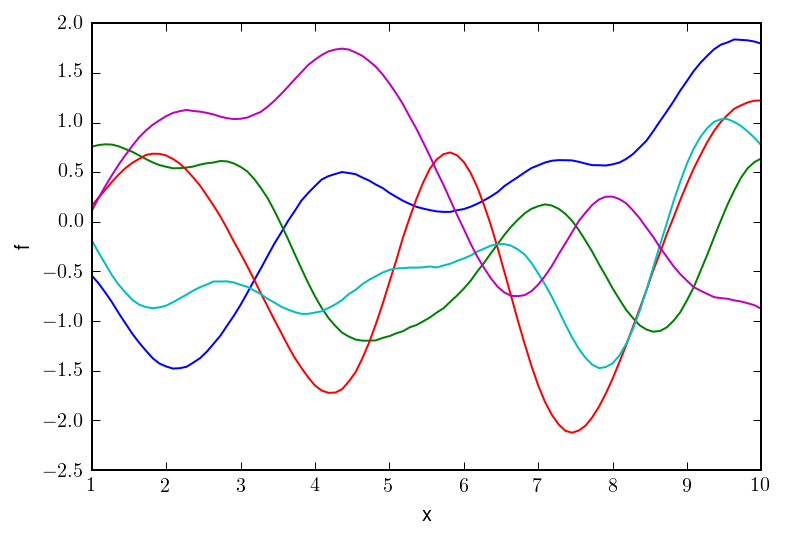

In [5]:
X = np.linspace(1,10,100).reshape(-1,1)
length_scale = 1.0
cov_scale = 1.0
K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
nugget_val = 1e-5
nugget = np.diag(nugget_val*np.ones(X.shape[0]))
for i in range(5):
    f = np.random.multivariate_normal(np.zeros(K.shape[0]), K+nugget)
    plt.plot(X,f)
plt.xlabel('x')
plt.ylabel('f')

Let's do the same with the Matern kernels for comparison:

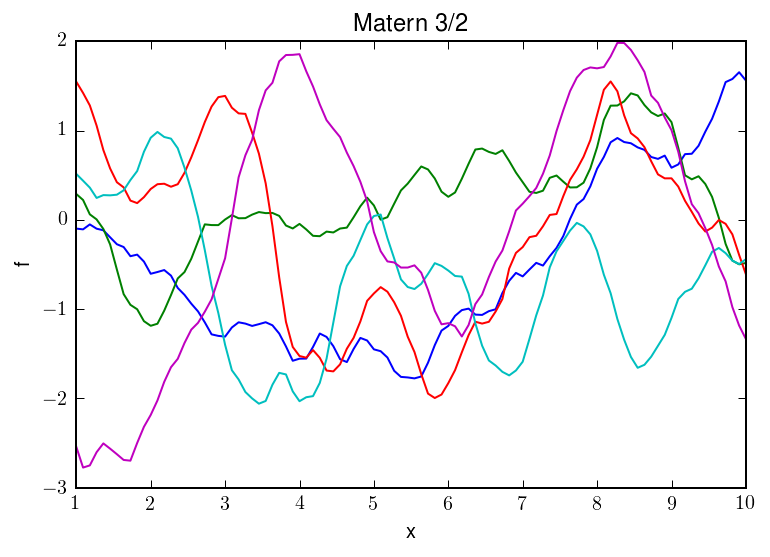

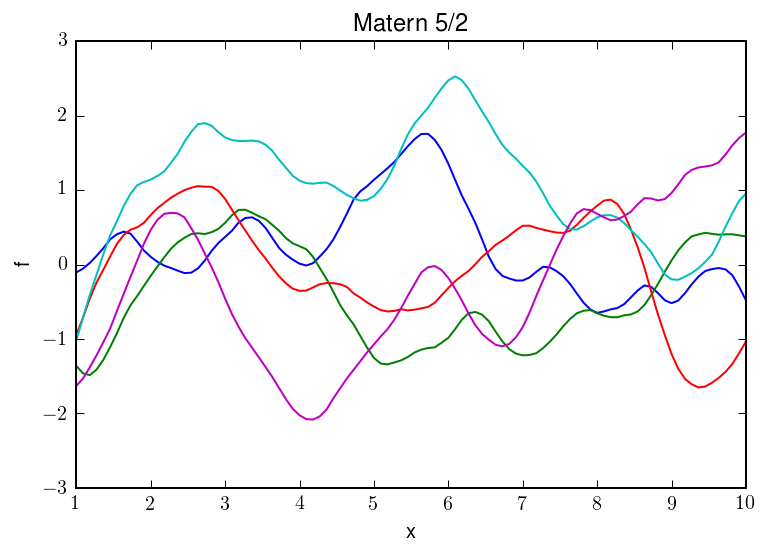

In [6]:
X = np.linspace(1,10,100).reshape(-1,1)
length_scale = 1.0
cov_scale = 1.0
K = cov_scale*Matern32(X,X,scale=length_scale,metric=None)
nugget_val = 1e-5
nugget = np.diag(nugget_val*np.ones(X.shape[0]))
for i in range(5):
    f = np.random.multivariate_normal(np.zeros(K.shape[0]), K+nugget)
    plt.plot(X,f)
plt.xlabel('x')
plt.ylabel('f')
plt.title('Matern 3/2')

plt.figure()
K = cov_scale*Matern52(X,X,scale=length_scale,metric=None)
nugget_val = 1e-5
nugget = np.diag(nugget_val*np.ones(X.shape[0]))
for i in range(5):
    f = np.random.multivariate_normal(np.zeros(K.shape[0]), K+nugget)
    plt.plot(X,f)
plt.xlabel('x')
plt.ylabel('f')
plt.title('Matern 5/2')

### Investigations:
1. How does the morphology of the GP samples change as you vary the length scale?
2. For the overall covariance scale?
3. What happens when the nugget is made very small?

### An Exercise:
Define an analogous K-matrix generator method for the Matern 3/2 kernel, and make the same plot as above.  

### Conditioning
Now let's condition the GP we created with our squared-exponential kernel.  To do this, we need to take the inverse of $K_{XX}$.  We will effectively do this via the Cholesky decomposition, which decomposes a matrix $K$ as $K=LL^\top$, where $L$ and $L^\top$ are lower and upper triangular matrices, respectively. Rather than directly find the inverse of $K$, we can solve for the vector ${\bf x}$ which fulfills the equation:
$$ {\bf y} = K{\bf x} = LL^\top{\bf x}$$
We write the solution as ${\bf x} = K\setminus {\bf y}$.  Substituting in the triangular matrices, we have ${\bf x} = L^\top\setminus (L \setminus {\bf y})$.  To solve for ${\bf b} = L \setminus {\bf y}$, use forward substitution and for $x = L^\top\setminus {\bf b}$ use backward substitution. With this inversion scheme in hand, we can write the numerical procedure algorithmically as (following Rasmussen and Williams Algorithm 2.1):

1. $L := {\rm Cholesky}(K)$
2. ${\bf \alpha} := L^\top \setminus (L \setminus {\bf f})$
3. ${\bf \bar{f}_*} := {\bf k}_*^\top {\bf \alpha}$
4. ${\bf v} := L \setminus {\bf k}_*$
5. $\mathbb{V} := {\bf k}_* - {\bf v}^\top {\bf v}$
6. $\log p({\bf f}|X) := -\frac{1}{2}{\bf f }^\top {\bf \alpha} - \sum_i L_{ii} - \frac{n}{2}\log(2\pi)$

Here, ${\bf k}_*:= k({\bf x_*},X)$ is the kernel function $k$ evaluated at the test point ${\bf x_*}$ and the set of input points $X$. If one is only interested in the mean ${\bf \bar{f}_*}$, then one only need save out ${\bf \alpha}$ as the trained interpolator.  If variances are desired (which is typically the point of using GPR), $L$ must also be saved.  Line 6 of the algorithm computes the log marginal likelihood of values ${\bf f}$ under the Gaussian process prior -- it will come in handy later.  In the cell below, we follow the algorithm above to condition a GP on a few known values of the sine function.  

The log likelihood is -23.5093041968


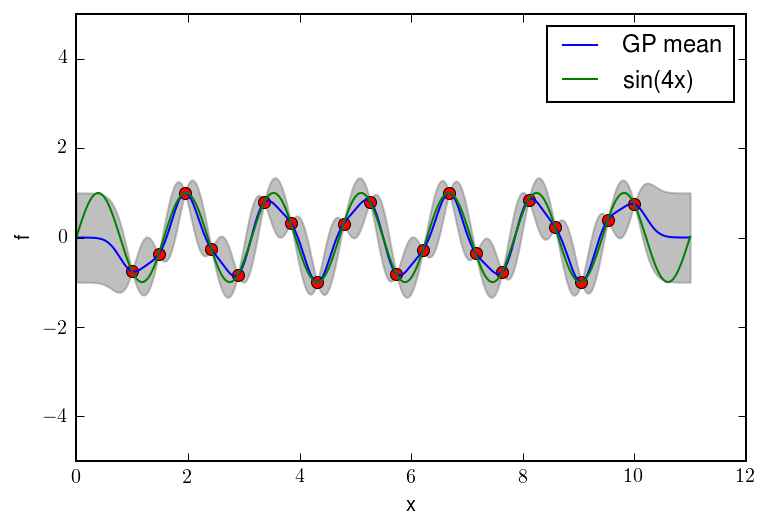

In [7]:
# The training points and training values
X = np.linspace(1,10,20).reshape(-1,1)
ferr = 1e-1
f = np.sin(4.*X)#+np.random.normal(0.,ferr,size=X.shape)

# The test points and real values of f at test points
Xstar = np.linspace(0,11,300).reshape(-1,1)
fstar = np.sin(4.*Xstar)

# Choose a kernel, nugget, and compute covariance matrices
length_scale = .05
cov_scale = 1.
KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)

nugget_val = 1e-2
nugget = np.diag((nugget_val**2)*np.ones(X.shape[0]))

# Steps 1-2
L = spl.cholesky(KXX+nugget,lower=True)
alpha = spl.cho_solve((L,True), f)

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = spl.solve_triangular(L,KXXstar[i,:],lower=True)
    variances.append(cov_scale-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (X.shape[0]/2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print 'The log likelihood is',lml

plt.plot(X,f,'ro')
plt.plot(Xstar,fstar_bar,label='GP mean')
plt.plot(Xstar,fstar,label='sin(4x)')

Xstar_flat,fstar_bar_flat=Xstar.flatten(),fstar_bar.flatten()
plt.fill_between(Xstar_flat,fstar_bar_flat-stds,fstar_bar_flat+stds,alpha=0.5,color='gray')
plt.ylim([-5,5])
plt.xlabel('x')
plt.ylabel('f')
plt.legend()

## Choosing the Kernel and Hyperparameters:
The kernel and it's associated hyperparameters are the bedrock of the Gaussian process regression and determine the overall morphology of the interpolations.  In most cases of interpolating smooth functions, the squared-exponential will suffice, and in simple cases one can even hand tune the hyperparameters.  In the machine-learning context though, one is more interested in fitting the hyperparameters to maximize some objective function of the observed data.  The squared-exponential kernel may not be right for all cases, either, as we shall see.  

The most natural objective function for deciding on kernel and/or hyperparameter choice is the log marginal likelihood, i.e. the probability of the observed data given the kernel/hyperparameter choice $p(f|k,\theta)$.  I call this the "hyperlikelihood". Let's perform the same interpolation as above but choose hyperparameters that maximize this.  One can also optionally introduce a "hyperprior" $p(\theta)$, ie. a prior distribution on hyperparameter values. This can be helpful if the marginal likelihood is not well behaved or has many local minima.  The "hyperposterior" $p(\theta|f)$ is given by:
$$ p(\theta,k|f) \propto p(f|k,\theta)p(\theta,k) $$

In [14]:
np.seterr(divide='raise',under='warn',over='raise')
def log_marginal_likelihood(theta,X,f,sign=1,cholesky=True,kernel='SE'):
    """
    Compute the log_marginal_likelihood of data f
    at points X under GP given by covariance K
    
    Parameters
    ----------
    theta: array
        array of hyperparameters 10**[nugget_val,cov_scale,length_scale]
    X: array
        array of GP input points
    f: array
        array of data at X
    sign: float
        A multiplier that is meant to be 1 or -1 
        depending on if one wants the negative or 
        positive log marginal likelihood
    Returns
    -------
    lml: float
        log marginal likelihood of data f
    """
    
    try:
        cov_scale = 10.**theta[0]
        length_scale = 10.**theta[1]
    except FloatingPointError:
        return -np.inf*sign
    try:
        if kernel == 'SE':
            K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
        elif kernel == 'Matern32':
            K = cov_scale*Matern32(X,X,scale=length_scale,metric=None)
        elif kernel == 'Matern52':
            K = cov_scale*Matern52(X,X,scale=length_scale,metric=None)
        if np.any(np.isnan(K)):
            print 'K has nans, returning nll = inf'
            print theta
            return -np.inf*sign
        nugget = np.diag((10.**theta[2])*np.ones(X.shape[0]))
        if cholesky:
            L = spl.cholesky(K+nugget,lower=True)
            alpha = spl.cho_solve((L,True), f)
            lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (X.shape[0]/2.)*np.log(2*np.pi)
            lml = lml.flatten()[0]
        else:
            Kinv = spl.inv(KXX+nugget)
            alpha = np.dot(Kinv,f)
            # Steps 3-5
            variances = []
            for i in range(KXXstar.shape[0]):
                v = np.dot(KXXstar[i,:].T,np.dot(Kinv,KXXstar[i,:]))
                variances.append(v)
            stds = np.sqrt(variances)
            # Step 6
            lml = -(1./2.)*np.dot(f.T,alpha) - 0.5*np.log(np.linalg.det(Kinv)) - (X.shape[0]/2.)*np.log(2*np.pi)
            lml = lml.flatten()[0]
    except:
        return -np.inf*sign
    return lml*sign


# def get_dK_dtheta(theta,X):
#     """
#     Compute dK/dtheta
    
#     Parameters
#     ----------
#     theta: array
#         list of hyperparameters
#     """
#     dK_dtheta = []
#     #npoints = X.shape[0]
#     #ndim = X.shape[1]
#     cov_scale = 10.**theta[0]
#     scale = 10.**theta[1]
#     cov_scale = theta[0]
#     scale = theta[1]
#     if isinstance(scale,(float,int)):
#         inv_scale=(1./scale)*np.ones(ndim)
#         inv_scale = np.diag(inv_scale)
#     else:
#         inv_scale = 1./scale
#         inv_scale = np.diag(inv_scale)
#     dist = lambda a,b: np.sqrt(np.dot(np.dot(a-b,inv_scale),a-b))
#     for n in range(len(theta)): 
#         if n==0:
#             dK_dtheta_n = squared_exponential_kernel(X,X,scale=scale,metric=None)
#         else:
#             dK_dtheta_n = np.empty([npoints,npoints])
#             for i in range(npoints):
#                 for j in range(npoints):
#                     dK_dtheta_n[i,j] = -0.5*cov_scale*(((X[i,:]-X[j,:])**2)/scale)
#             dK_dtheta_n = np.multiply(dK_dtheta_n,squared_exponential_kernel(X,X,scale=scale,metric=None))
#         dK_dtheta.append(dK_dtheta_n)
#     return dK_dtheta

# def get_dLogP_dtheta_SE(theta,X,f,sign=1):
#     """
#     Compute the gradient of the log
#     likelihood for the squared exponential
#     as a function of hyperparameters
#     """
#     cov_scale = 10.**theta[0]
#     length_scale = 10.**theta[1]
#     #cov_scale = theta[0]
#     #length_scale = theta[1]
#     npoints = X.shape[0]
#     nhyperparam = len(theta)
#     K = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
#     Kinv = spl.inv(K)
#     alpha = np.dot(Kinv,f)
#     dK_dtheta = get_dK_dtheta(theta,X)
#     Kinvf = np.dot(Kinv,f)
#     dLogP_dtheta_SE = []
#     for n in range(nhyperparam):
#         dLogP_dtheta_SE_n = 0.5*(np.dot(np.dot(Kinvf.T,dK_dtheta[n]),Kinvf) - np.trace(np.dot(Kinv,dK_dtheta[n])))
#         dLogP_dtheta_SE.append(dLogP_dtheta_SE_n[0,0])

#     return np.array(dLogP_dtheta_SE)*sign
        
from scipy.stats import norm
def log_hyperprior(theta,theta_means,theta_widths,prior_type='normal'):
    """
    The log hyperprior
    
    Parameters
    ----------
    theta: array
        array of parameter values
    theta_means: array
        array of mean values of theta
    theta_widths: array
        gaussian widths of theta values
    prior_type: string
        either normal or box
    
    Returns
    -------
    log_h: float
        log hyperprior
    """
    log_h = 0.
    for i in range(len(theta)):
        try:
            if prior_type=='normal':
                log_h = log_h + np.log(norm.pdf(theta[i], theta_means[i], theta_widths[i]))
            else:
                if ~((theta[i]>(theta_means[i]-theta_widths[i])) and 
                    (theta[i]<(theta_means[i]+theta_widths[i]))):
                    log_h = -np.inf
                else:
                     pass                                                     
        except:
            -np.inf
    return log_h

def log_hyperposterior(theta,X,f,
                       theta_means,theta_widths,
                       sign=1,cholesky=True,
                       kernel='SE',prior_type='normal'):
    """
    The log hyperposterior
    
    Parameters
    ----------
    theta: array
        array of hyperparameters
    X: array
        array of GP input points
    f: array
        array of data at X
    theta_means: array
        array of mean values of lognormal prior
    theta_widths: array
        widths of lognormal prior
    sign: float
        1 or -1 depending on if negative 
        log hyperposterior is wanted
    Returns
    -------
    log_hyperposterior: float
        the log hyperposterior
    """
    hyperpos = (log_marginal_likelihood(theta,X,f,cholesky=cholesky,kernel=kernel)+
                log_hyperprior(theta,theta_means,theta_widths,prior_type))
    if np.isnan(hyperpos):
        return -np.inf*sign
    else:
        return hyperpos*sign

If you want a look at the hyperlikelihood or hyperposterior as a function of the hyperparameters, you can use an mcmc:

/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: underflow encountered in exp
/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: underflow encountered in multiply


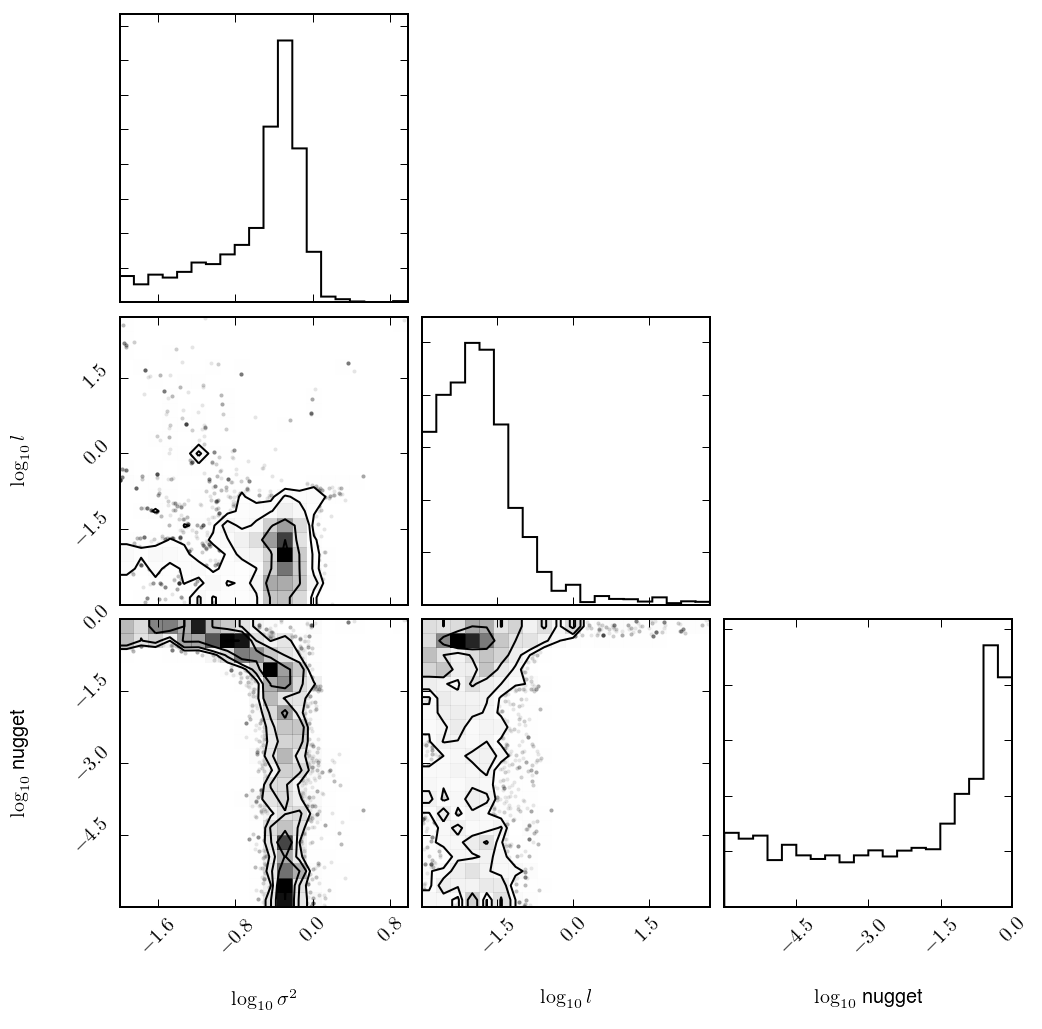

In [15]:
ndim, nwalkers = 3, 20
theta_means = [0.0,0.0,-3]
theta_widths = [2.,3.,3.] # order of mag width on covariance and length, 0.1 orders on nugget
sampler = mc.EnsembleSampler(nwalkers, ndim, log_hyperposterior, args=(X, f,theta_means,theta_widths,1,True,'SE','box'))


pos = [[0.,0.,-3.] + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, 500);
import corner
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
corner.corner(samples, labels=["$\log_{10}\sigma^2$", "$\log_{10} l$","$\log_{10}$ nugget"]);

You may notice that there are multiple local extrema to the objective functions we are trying to maximize/minimize.  As a result, some tweaking or multiple optimizer restarts may be required if we want to just use the hyperparameters at extrema of the objective function.  One could in principle take an even more Bayesian approach and marginalize over hyperparameters rather than choosing one set of hyperparameters.  This would be total overkill in most applications. It's also worth noting that the hyperposterior's profile is telling us about different ways to explain the data (duh, it's Bayes!).  In this case with the sinusoidal data, it could be that all the data could be explained as mostly noise or it could instead be that there is a small amount of noise in the data and that $\sigma^2 \sim 10^{-0.4}$ and $l \sim 10^{-2}$.  In some cases you may know the noise level, in which case it can be fixed and the other hyperparameters can be optimized.  Let's fix the nugget to 1e-2 and see how the other hyperparameters are optimized:

/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: underflow encountered in exp
/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: underflow encountered in multiply


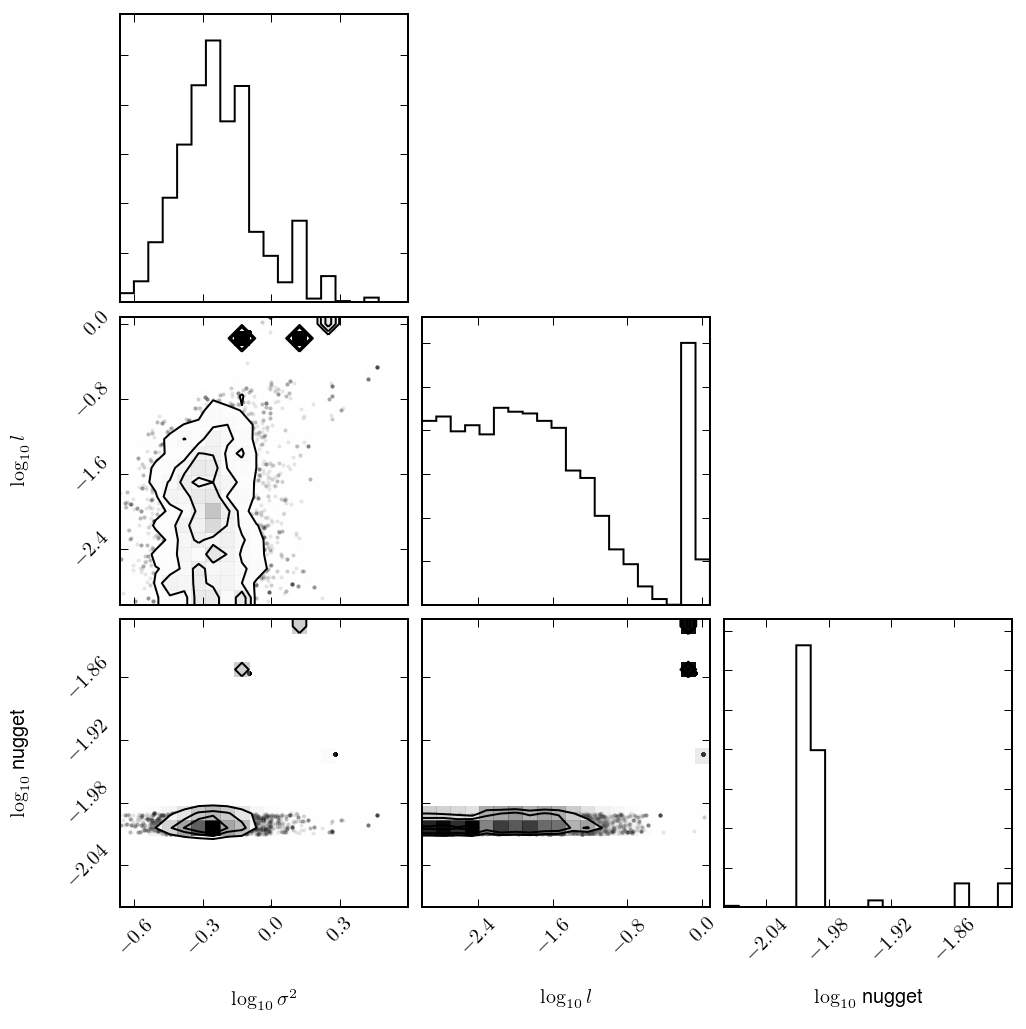

In [16]:
ndim, nwalkers = 3, 20
theta_means = [0.0,0.0,-2]
theta_widths = [2.,3.,0.01] # order of mag width on covariance and length, 0.1 orders on nugget
sampler = mc.EnsembleSampler(nwalkers, ndim, log_hyperposterior, args=(X, f,theta_means,theta_widths,1,True,'SE','box'))

pos = [[0.,0.,-2.] + 0.1*np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, 500);
import corner
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
corner.corner(samples, labels=["$\log_{10}\sigma^2$", "$\log_{10} l$","$\log_{10}$ nugget"]);

Let's minimize the negative log marginal likelihood for data f assuming a "nugget" of 1e-2.  In order to make the minimization easy, we've used the above corner plots to inform the hyperprior to carve out the area of parameter space where we want the minimizer to search:

In [17]:
minres = None
minresval = np.inf
bounds = ([-0.5,0.0],[-3,-1],[-2.1,-1.92])
x0 = [-0.25,-2.,-2.]
res = spo.minimize(log_hyperposterior,
                   x0=x0,
                   args=(X,f,theta_means,theta_widths,-1.,True,'SE','normal'),
                   bounds = bounds,
                  )
print res
# theta_widths = [2.,3.,0.1]
# for i in range(200):
#     sel = False
#     while ~sel:
#         x0 = [0.0,0.0,-2]+0.2*np.multiply(np.random.randn(3),[1.,1.,0.01]) 
#         sel = True
#         for j in range(len(x0)):
#             sel = sel and (x0[j]<bounds[j][1]) and (x0[j]>bounds[j][0])
#     res = spo.minimize(log_hyperposterior,
#                        x0=x0,
#                        args=(X,f,theta_means,theta_widths,-1.,True,'SE','normal'),
#                        bounds = bounds,
#                       )
#     if ((res["fun"]<minresval) and (res["fun"]!=(-np.inf))):
#         minres = res

# print minres
#res = spo.minimize(log_marginal_likelihood,x0=[1.,1.],args=(X,f),jac=get_dLogP_dtheta_SE)

/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: underflow encountered in exp
/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: underflow encountered in multiply


      fun: 21.477940909122236
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.55271368e-07,  -3.55271368e-07,   3.19744231e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 10
   status: 0
  success: True
        x: array([-0.31221121, -1.71682949, -2.0000001 ])


/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: RuntimeWarning: underflow encountered in exp
/Users/Zoheyr/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: underflow encountered in multiply


The log likelihood is -3.89876922078


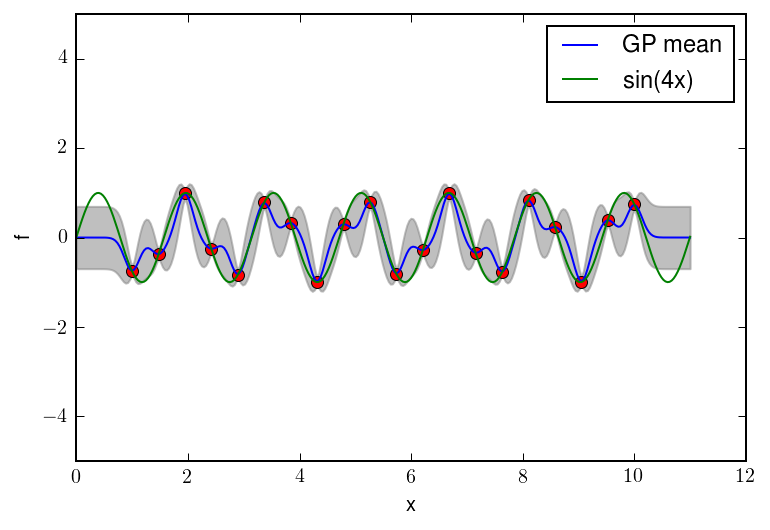

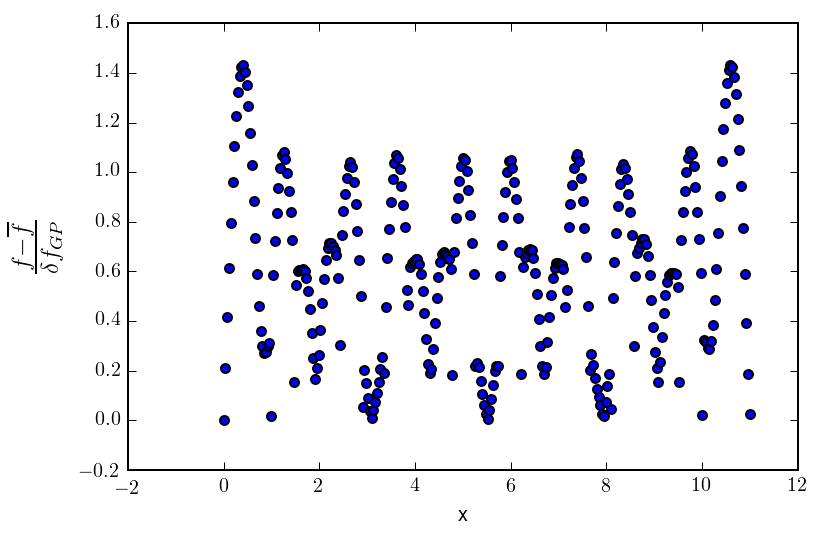

In [19]:

# Use optimized hyperparameters
cov_scale = 10**res["x"][0]
length_scale = 10**res["x"][1]
nugget_val = 10**res["x"][2]

nugget = np.diag(nugget_val*np.ones(X.shape[0]))
# avoid underflow errors by working in log space:
KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)

# Steps 1-2
L = spl.cholesky(KXX+nugget,lower=True)
alpha = spl.cho_solve((L,True), f)

# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = spl.solve_triangular(L,KXXstar[i,:],lower=True)
    variances.append(cov_scale-np.dot(v.T,v))
stds = np.sqrt(variances)

# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (1./2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print 'The log likelihood is',lml

plt.plot(X,f,'ro')
plt.plot(Xstar,fstar_bar,label='GP mean')
plt.plot(Xstar,fstar,label='sin(4x)')

Xstar_flat,fstar_bar_flat=Xstar.flatten(),fstar_bar.flatten()
plt.fill_between(Xstar_flat,fstar_bar_flat-stds,fstar_bar_flat+stds,alpha=0.5,color='gray')
plt.ylim([-5,5])
plt.xlabel('x')
plt.ylabel('f')
plt.legend()

plt.figure()
plt.scatter(Xstar,np.divide(np.abs(fstar-fstar_bar).flatten(),stds),label='mean residual')
plt.xlabel('x')
plt.ylabel(r'$\frac{f-\overline{f}}{\delta f_{GP}}$',fontsize=18)

We've now finished running a trained Gaussian Process Regression!  

## Gravitational Wave Example

Now let's look at a gravitational-wave example!  Rather than interpolate full waveforms, which is beyond what we have time for in this tutorial, we will instead interpolate fraction of mass loss from binary mergers as a function of mass ratio.  At our disposal, we have SXS simulations of black hole mergers.  Some outputs of these simulations include radiated energies.  Let's first get the data and plot it:

In [43]:
def LoadMetaData ( ID ):
    
    fname = "GPR_Chris_Zoheyr/data/SXS_data/" + ID + "/metadata" + ID.split('-')[1] + ".txt"
    
    with open(fname) as f:
        content = f.readlines()
    
    for line in content:
        if "relaxed-mass1" in line:
            relaxed_mass1 = float ( line.split()[-1] )
        elif "relaxed-mass2" in line:
            relaxed_mass2 = float ( line.split()[-1] )
        elif "remnant-mass" in line:
            remnant_mass = float ( line.split()[-1] )
    
    total_mass = relaxed_mass1 + relaxed_mass2
    mass_ratio = relaxed_mass1 / relaxed_mass2
    Delta_E = ( total_mass - remnant_mass ) / total_mass
    
    return np.array ( [ mass_ratio , Delta_E ] )

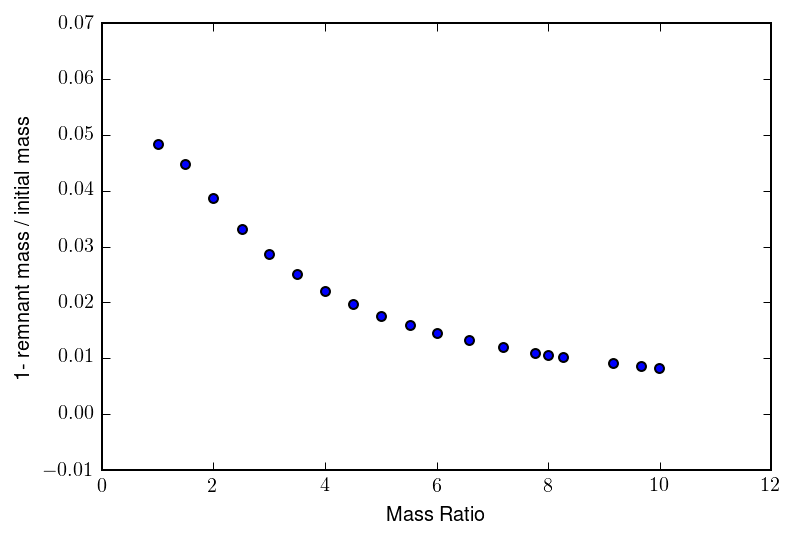

In [44]:
import os
ids = os.listdir ( "GPR_Chris_Zoheyr/data/SXS_data/" )
mass_ratios = []
energies = []
for idval in ids:
    mass_ratio, Delta_E = LoadMetaData ( idval )
    mass_ratios.append(mass_ratio)
    energies.append(Delta_E)
mass_ratios,energies = np.array(mass_ratios),np.array(energies)
plt.scatter(mass_ratios,energies)
plt.xlabel('Mass Ratio')
plt.ylabel('1- remnant mass / initial mass')

Unsurprisingly, the remnant mass over the initial mass goes to zero as the mass ratio is increased. This makes sense in the high mass ratio limit where one would expect no energy radiated from throwing a teeny black hole into a super-massive one.  Let's start by breaking the data set into a training set and a validation set.  We'll use 8 of the 19 simulations to train:  

In [45]:
np.random.seed(0)
indices = np.random.choice(range(len(mass_ratios)),replace=False,size=10)
sel = np.in1d(np.array(range(len(mass_ratios))),indices)
q_train = mass_ratios[sel]
q_val = mass_ratios[~sel]
E_train = energies[sel]
E_val = energies[~sel]

Before we interpolate, we should whiten our data by removing the mean and normalizing by the standard deviation.  We can also normalize q_train to be between 0 and 1.  This is a very helpful move in general, because that way we can use the same hyperparameter bounds in all interpolations.

In [46]:
E_train_mean = np.mean(E_train)
E_train_std = np.std(E_train)
E_train_whitened = ((E_train-E_train_mean)/E_train_std).reshape(-1,1)
E_val_whitened = ((E_val-E_train_mean)/E_train_std).reshape(-1,1)
q_train_min = np.amin(q_train)
q_train_max = np.amax(q_train)
q_train_whitened = ((q_train-q_train_min)/(q_train_max-q_train_min)).reshape(-1,1)
q_val_whitened = ((q_val-q_train_min)/(q_train_max-q_train_min)).reshape(-1,1)

Now let's train the GP:

K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan  nan  nan]
K has nans, returning nll = inf
[ nan   2.  nan]
K has nans, returning nll = inf
[ nan   2.  nan]
K has nans, returning nll = inf
[        nan  2.00000001         nan]
K has nans, returning nll = inf
[ nan   2.  nan]
K has nans, returning nll = inf
[ nan   2.  nan]
K has nans, returning nll = inf
[ nan   2.  nan]
K has nans, returning nll = inf
[        nan  2.00000001         nan]
K has nans, returning nll =

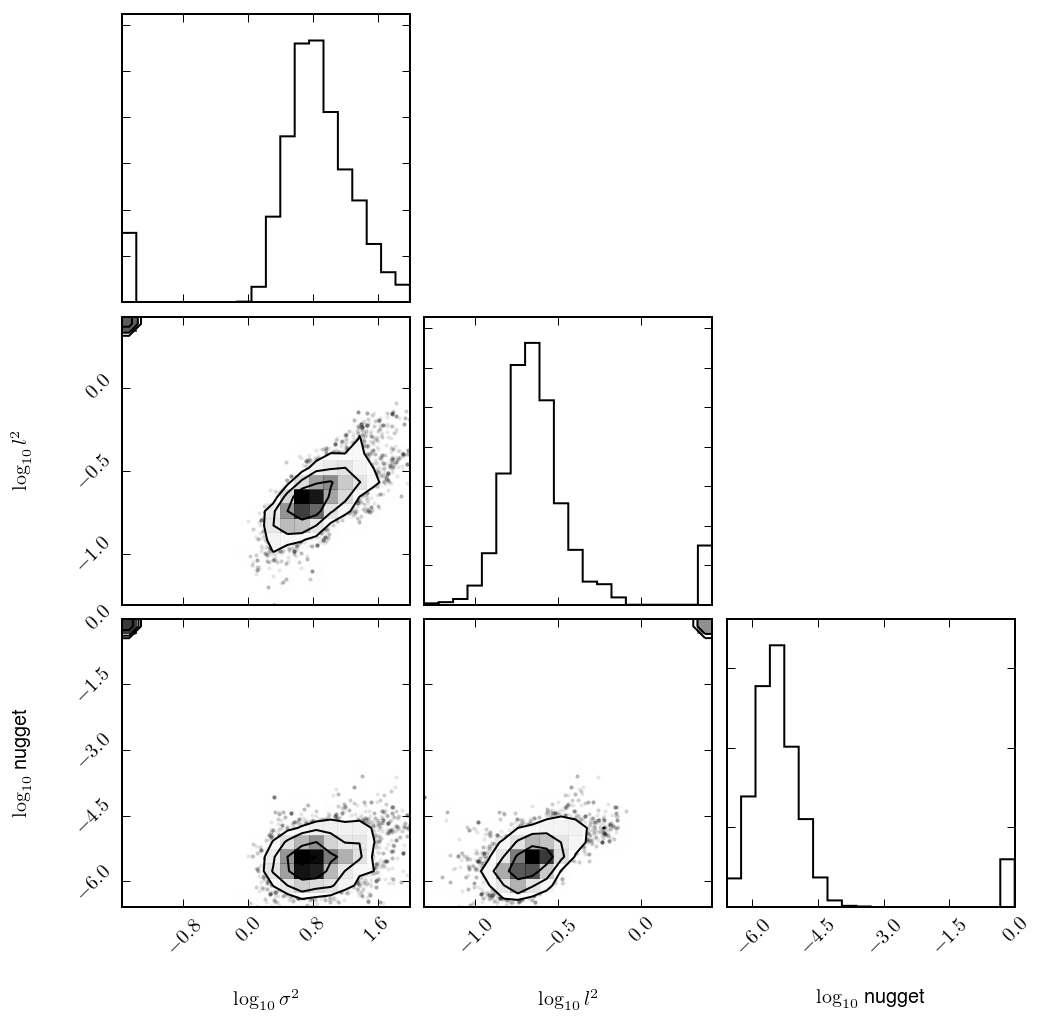

In [47]:
ndim, nwalkers = 3, 20
theta_means = [0.0,0.0,-4.]
theta_widths = [2,2,4]

sampler = mc.EnsembleSampler(nwalkers, ndim, log_hyperposterior, 
                             args=(q_train_whitened, E_train_whitened,theta_means,theta_widths,1,True,'SE','box'))

pos = [[0.,0.,-2.] + np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos, 500);
import corner
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
corner.corner(samples, labels=["$\log_{10}\sigma^2$", "$\log_{10} l^2$","$\log_{10}$ nugget"]);

# run the optimizer too to find the max hyperposterior.  We'll do a few restarts
# since the optimizer can misbehave

reslist = []
minhpi = None
minhp = np.inf
for i in range(20):
    res = spo.minimize(log_hyperposterior,x0=[0.0,-1.,-2]+ np.random.randn(ndim),
                       args=(q_train_whitened, E_train_whitened,theta_means,theta_widths,-1.,True,'SE','box'),
                       bounds=([-2,2],[-2,2],[-8,0]))
    reslist.append(res)
    if res["fun"]< minhp:
        minhp = res["fun"]
        minhpi = i
print reslist[minhpi]

The log likelihood is -5.07163744938


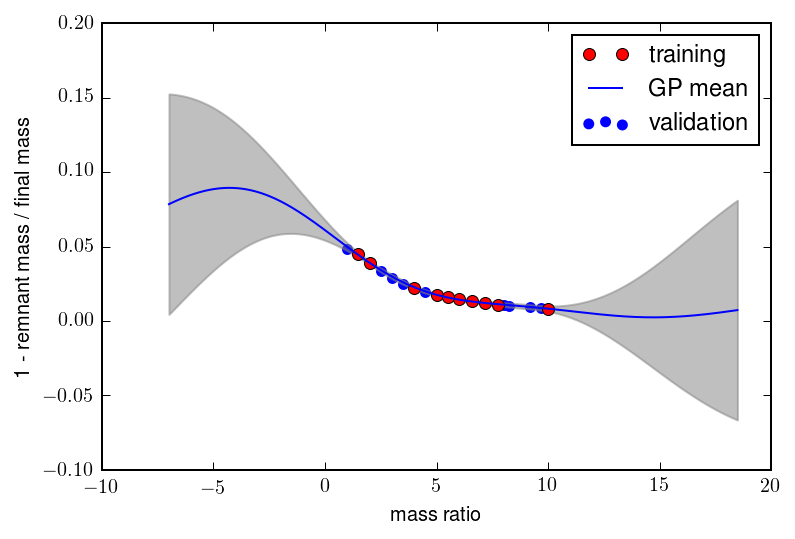

In [48]:
X = q_train_whitened
f = E_train_whitened
Xstar = np.linspace(-1.,2.,500).reshape(-1,1)
#Xstar = np.array(sorted(q_val_whitened)).reshape(-1,1)
# Use optimized hyperparameters
reslist[minhpi]
cov_scale = 10**res["x"][0]
length_scale = 10**res["x"][1]
nugget_val = 10**res["x"][2]
nugget = np.diag(nugget_val*np.ones(X.shape[0]))
KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)

# Steps 1-2
#L = spl.cholesky(KXX+nugget,lower=True)
L = np.linalg.cholesky(KXX+nugget)
alpha = spl.cho_solve((L,True), f)
# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = spl.solve_triangular(L,KXXstar[i,:],lower=True)
    variances.append(cov_scale-np.dot(v.T,v))
stds = np.sqrt(variances)
# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (X.shape[0]/2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print 'The log likelihood is',lml

plt.plot(q_train,E_train,'ro',label='training')
plt.scatter(q_val,E_val,color='b',label='validation')
qstar = Xstar*(q_train_max-q_train_min)+q_train_min
Estar_bar = fstar_bar*E_train_std+E_train_mean
plt.plot(qstar,Estar_bar,label='GP mean')
qstar_flat,Estar_bar_flat=qstar.flatten(),Estar_bar.flatten()
stds = stds*E_train_std
plt.fill_between(qstar_flat,Estar_bar_flat-stds,Estar_bar_flat+stds,alpha=0.5,color='gray')
#plt.ylim([-5,5])
plt.xlabel('mass ratio')
plt.ylabel('1 - remnant mass / final mass')
plt.legend()

And now let's compare our GP uncertainties to the residuals with the mean

[ 0.00660505  0.00217681  0.0021128   0.00321209  0.00610452  0.00115428
  0.00202707  0.00189079  0.00438497]
The log likelihood is 12.9300814803
[[ 0.24353286]
 [ 0.00374864]
 [ 0.01535829]
 [-0.00052771]
 [ 0.00407854]
 [-0.00568522]
 [ 0.01304553]
 [ 0.00480499]
 [ 0.00444642]]


(0.1, 10)

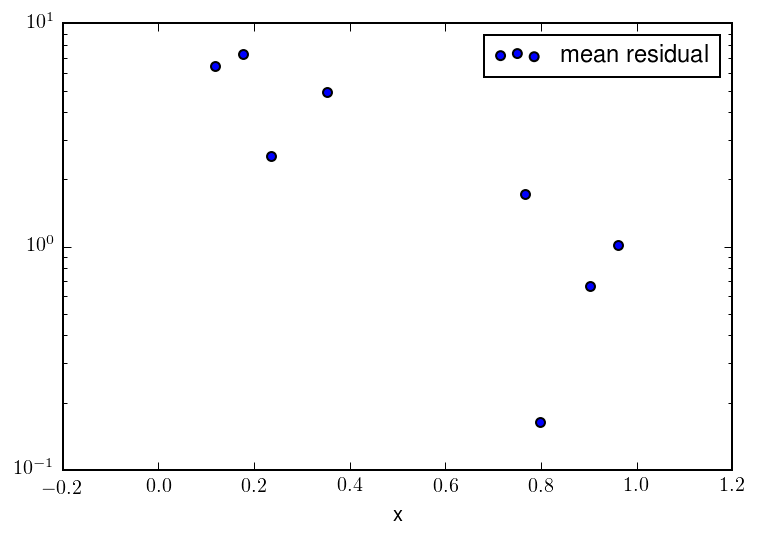

In [52]:
X = q_train_whitened
f = E_train_whitened
Xstar = q_val_whitened
# Use optimized hyperparameters

cov_scale = 10**0.7
length_scale = 10**-0.6
nugget_val = 10**-5.6
nugget = np.diag(nugget_val*np.ones(X.shape[0]))
KXX = cov_scale*squared_exponential_kernel(X,X,scale=length_scale,metric=None)
KXXstar = cov_scale*squared_exponential_kernel(Xstar,X,scale=length_scale,metric=None)

# Steps 1-2
#L = spl.cholesky(KXX+nugget,lower=True)
L = np.linalg.cholesky(KXX+nugget)
alpha = spl.cho_solve((L,True), f)
# Steps 3-5
fstar_bar = np.dot(KXXstar,alpha)
variances = []
for i in range(KXXstar.shape[0]):
    v = spl.solve_triangular(L,KXXstar[i,:],lower=True)
    variances.append(cov_scale-np.dot(v.T,v))
stds = np.sqrt(variances)
print stds
# Step 6
lml = -(1./2.)*np.dot(f.T,alpha) - np.sum(np.log(np.diag(L))) - (X.shape[0]/2.)*np.log(2*np.pi)
lml = lml.flatten()[0]
print 'The log likelihood is',lml

print fstar_bar - E_val_whitened
plt.scatter(Xstar,np.absolute(fstar_bar - E_val_whitened).flatten()/stds,label='mean residual')
#plt.scatter(Xstar,stds,label='stds',color='r')
plt.xlabel('x')
plt.legend()
plt.yscale('log')
plt.ylim([1e-1,10])

### Final Investigations
* How do the residuals look?
* If the residuals don't match the expected uncertainties, what changes could you make to e.g. your kernel in order to fix it?